In [17]:
# path = 'configs/small-middle-cycle/energy/profile3/series/'
# path = 'configs/triangle5/train/energy/profile3/series/'
path = 'results/'

In [18]:
import pandas as pd
dijkstra = pd.read_csv(path + '1bag_time_dijkstra_entries.csv', sep=',')
ppo = pd.read_csv(path + '1bag_time_ppo_entries.csv', sep=',')
dqn = pd.read_csv(path + '1bag_time_dqn_entries.csv', sep=',')

In [19]:
ppo.values[:, 1].std() / dijkstra.values[:, 1].std(), dqn.values[:, 1].std() / dijkstra.values[:, 1].std()

(1.071184632099059, 1.0727472977768908)

In [20]:
ppo.values[:, 1].mean() / dijkstra.values[:, 1].mean(), dqn.values[:, 1].mean() / dijkstra.values[:, 1].mean()

(1.043504076850487, 1.039050820141444)

In [21]:
def plot(energy, label):
    energy = energy.copy()
    energy['time'] //= n
    energy = energy.groupby('time').agg('mean')
    energy.index *= n
    plt.plot(energy.index, energy['value'], label=label, linewidth=3.0)

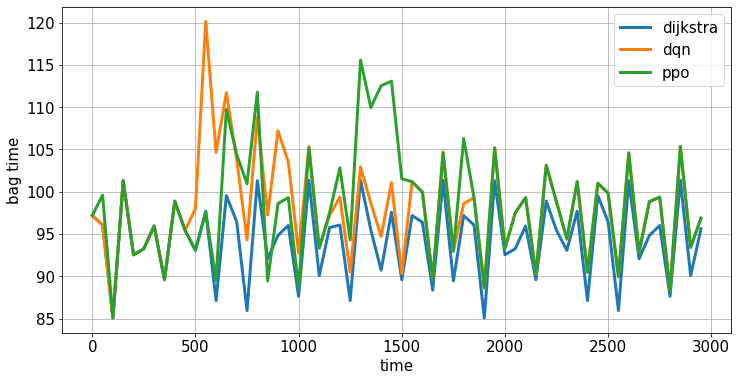

In [22]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 15})

n = 50
plt.figure(figsize=(12, 6))
plot(dijkstra, 'dijkstra')
plot(dqn, 'dqn')
plot(ppo, 'ppo')
plt.grid(True)
plt.xlabel('time')
plt.ylabel('bag time')
plt.legend()
plt.show()

In [23]:
dijkstra_energy = pd.read_csv(path + '1energy_consumption_dijkstra_entries.csv', sep=',')
ppo_energy = pd.read_csv(path + '1energy_consumption_ppo_entries.csv', sep=',')
dqn_energy = pd.read_csv(path + '1energy_consumption_dqn_entries.csv', sep=',')
time = dijkstra_energy.loc[int(len(dijkstra_energy) * 0.0), 'time']
dijkstra_energy = dijkstra_energy[dijkstra_energy['time'] > time]
ppo_energy = ppo_energy[ppo_energy['time'] > time]
dqn_energy = dqn_energy[dqn_energy['time'] > time]

In [24]:
ppo_energy.values[:, 1].std() / dijkstra_energy.values[:, 1].std(), dqn_energy.values[:, 1].std() / dijkstra_energy.values[:, 1].std()

(1.4473524478291744, 1.471167545240194)

In [25]:
ppo_energy.values[:, 1].sum() / dijkstra_energy.values[:, 1].sum(), dqn_energy.values[:, 1].sum() / dijkstra_energy.values[:, 1].sum()

(1.0080995422930947, 0.9949201174705634)

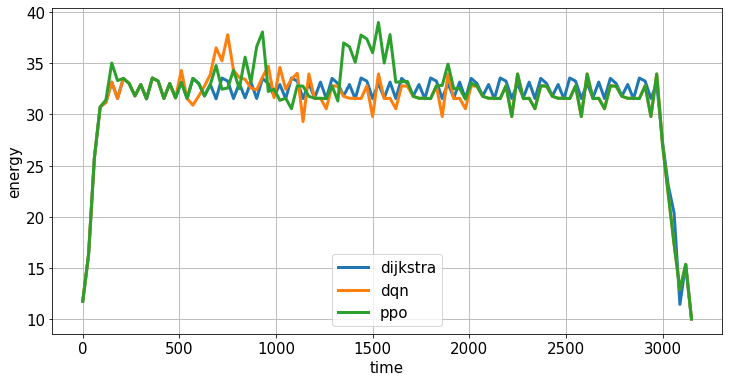

In [26]:
from matplotlib import pyplot as plt

n = 30
plt.figure(figsize=(12, 6))
plot(dijkstra_energy, 'dijkstra')
plot(dqn_energy, 'dqn')
plot(ppo_energy, 'ppo')
plt.grid(True)
plt.xlabel('time')
plt.ylabel('energy')
plt.legend()
plt.show()

In [2]:
import json
import numpy as np

class Source:
    def __init__(self, source_idx, upstream_idx):
        self.source_idx = source_idx
        self.upstream_idx = upstream_idx
    
    def to_json(self):
        return f'"{self.source_idx}": {{ "upstream_conv": {self.upstream_idx} }}'
    
class Sink:
    def __init__(self, sink_idx):
        self.sink_idx = sink_idx
    
    def to_json(self):
        return f'{self.sink_idx}'

class Diverter:
    def __init__(self, diverter_idx, conveyor_idx, pos, upstream_idx):
        self.diverter_idx = diverter_idx
        self.conveyor_idx = conveyor_idx
        self.pos = pos
        self.upstream_idx = upstream_idx
        
    def to_json(self):
        return f'"{self.diverter_idx}": {{ "conveyor": {self.conveyor_idx}, "pos": {self.pos}, "upstream_conv": {self.upstream_idx} }}'
    
class Conveyor:
    def __init__(self, conveyor_idx, length, quality, upstream_type, upstream_idx, upstream_pos = None):
        self.conveyor_idx = conveyor_idx
        self.length = length
        self.quality = quality
        self.upstream_type = upstream_type
        self.upstream_idx = upstream_idx
        self.upstream_pos = upstream_pos
            
    def to_json(self):
        pos = f', "pos": {self.upstream_pos}' if self.upstream_pos else ''
        return f'"{self.conveyor_idx}": {{ "length": {self.length}, "quality": {self.quality}, "upstream": {{ "type": "{self.upstream_type}", "id": {self.upstream_idx}{pos} }} }}'

def to_jsons(items):
    return [item.to_json() for item in items]
    
def json_topology(sources, sinks, diverters, conveyors):
    sources = to_jsons(sources)
    sinks = to_jsons(sinks)
    diverters = to_jsons(diverters)
    conveyors = to_jsons(conveyors)
    topology_str = f'{{ "topology": {{ "type": "oriented", "sources": {{ {", ".join(sources)} }}, "sinks": [{", ".join(sinks)}], "diverters": {{ {", ".join(diverters)} }}, "conveyors": {{ {", ".join(conveyors)} }} }} }}'
    return json.dumps(json.loads(topology_str), indent=2)

def random_quality():
    return np.random.choice([1.0, 1.5, 2.5])

In [6]:
topology = json_topology(
    [Source(0, 0), Source(1, 4), Source(2, 5), Source(3, 2)],
    [Sink(0), Sink(1), Sink(2)],
    [
        Diverter(0, 0, 20, 3), Diverter(1, 0, 40, 1), Diverter(2, 1, 25, 7),
        Diverter(3, 2, 30, 6), Diverter(4, 6, 30, 8)
    ],
    [
        Conveyor(0, 50, 1, 'sink', 0), Conveyor(1, 30, 1, 'sink', 1), Conveyor(2, 50, 1, 'sink', 2),
        Conveyor(4, 20, 1, 'conveyor', 3, 20), Conveyor(5, 20, 1, 'conveyor', 3, 40), Conveyor(3, 60, 1, 'conveyor', 2, 20),
        Conveyor(6, 40, 1, 'conveyor', 1, 20), Conveyor(7, 30, 1, 'conveyor', 2, 45), Conveyor(8, 35, 1, 'conveyor', 0, 25)
    ]
)
print(topology)

{
  "topology": {
    "type": "oriented",
    "sources": {
      "0": {
        "upstream_conv": 0
      },
      "1": {
        "upstream_conv": 4
      },
      "2": {
        "upstream_conv": 5
      },
      "3": {
        "upstream_conv": 2
      }
    },
    "sinks": [
      0,
      1,
      2
    ],
    "diverters": {
      "0": {
        "conveyor": 0,
        "pos": 20,
        "upstream_conv": 3
      },
      "1": {
        "conveyor": 0,
        "pos": 40,
        "upstream_conv": 1
      },
      "2": {
        "conveyor": 1,
        "pos": 25,
        "upstream_conv": 7
      },
      "3": {
        "conveyor": 2,
        "pos": 30,
        "upstream_conv": 6
      },
      "4": {
        "conveyor": 6,
        "pos": 30,
        "upstream_conv": 8
      }
    },
    "conveyors": {
      "0": {
        "length": 50,
        "quality": 1,
        "upstream": {
          "type": "sink",
          "id": 0
        }
      },
      "1": {
        "length": 30,
        "qualit

In [ ]:
n = 3
a = 10
l = 15
sources = [Source(i, i) for i in range(n)]
sinks = [Sink(i) for i in range(n)]
diverters = []
for i in range(n - 1):
    for j in range(n):
        diverters.append(Diverter(n + i * n * 2 + j, i, a + 4 * j * a, 2 * n + i * n * 2 + j))
for i in range(1, n):
    for j in range(n):
        diverters.append(Diverter(n + i * n * 2 + j + n, i, 3 * a + 4 * j * a, 3 * n + i * n * 2 + j))
for i in range(n):
    diverters.append(Diverter(i, i, 4 * a * (n + 2), i + n))
conveyors = []
for i in range(n - 1):
    for j in range(n):
        conveyors.append(Conveyor(2 * n + i * n * 2 + j, l + round(np.random.rand() * 10), random_quality(), 'conveyor', i + 1, 2 * a + 4 * j * a))
for i in range(1, n):
    for j in range(n):
        conveyors.append(Conveyor(3 * n + i * n * 2 + j, l + round(np.random.rand() * 10), random_quality(), 'conveyor', i - 1, 4 * a + 4 * j * a))
for i in range(n):
    conveyors.append(Conveyor(i, 4 * a * (n + 5), random_quality(), 'sink', i))
    conveyors.append(Conveyor(i + n, 5 * l, random_quality(), 'conveyor', (i + 1) % n, 4 * a * (n + 2) - 2 * a))
topology = json_topology(sources, sinks, diverters, conveyors)
print(topology)